In [1]:
import numpy as np
from sklearn import datasets
from typing import Tuple
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchinfo import summary


# NOTE: I don't work to seed everything carefully here, but we could, it's just complicated
def gensamples(samples_per_class=100, xor=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return two arrays of x and y values for a simple classification dataset made
    of blobs.
    """
    # NOTE: The homework doesn't have an xor but this is probably good to have
    if xor:
        # Make centers
        centers = np.array(([-2, -2], [2, 2], [-2, 2], [2, -2]))
        x, y = datasets.make_blobs(n_samples=samples_per_class * 4, centers=centers)

        # Change class 1 to 0
        y[y == 1] = 0

        # Combine the other class
        y[y == 2] = 1
        y[y == 3] = 1

        # Split x's based on y
        return x[y == 0], x[y == 1]
    else:
        # Make centers
        centers = np.array(([-2, -2], [2, 2]))
        x, y = datasets.make_blobs(n_samples=samples_per_class * 2, centers=centers)

        # NOTE: I did extra work to make the outputs less useful to match homework description
        # Split x's based on y
        return x[y == 0], x[y == 1]


# NOTE: I don't quite remember what was in the homework, so now this is just a function that takes the model and the samples
def plottest(model, samples) -> None:
    # Create a grid of points
    x = np.linspace(-7, 7, 100)
    y = np.linspace(-7, 7, 100)
    xx, yy = np.meshgrid(x, y)

    # Flatten the grid
    xx = xx.flatten()
    yy = yy.flatten()

    # Combine the grid
    grid = np.stack((xx, yy), axis=1)

    # Predict the grid
    grid = torch.tensor(grid, dtype=torch.float32)
    grid = model(grid)

    # Reshape the grid
    grid = grid.detach().numpy().reshape(100, 100)

    # Create contour plot
    plt.contourf(x, y, grid, levels=1, cmap="coolwarm", alpha=0.5)

    # Plot the samples
    samples = samples.numpy()
    half = len(samples) // 2

    # Half samples are blue, other is red
    plt.plot(samples[:half, 0], samples[:half, 1], "bo")
    plt.plot(samples[half:, 0], samples[half:, 1], "ro")

    plt.show()

In [2]:
epochs = 5
batch_size = 20

In [3]:
sample1, sample2 = gensamples(xor=False)

# Assemble samples into a single array
samples = np.concatenate((sample1, sample2))
samples = torch.tensor(samples, dtype=torch.float32)

# Make labels
labels = np.concatenate((np.zeros(sample1.shape[0]), np.ones(sample2.shape[0])))
# NOTE: We need to add an extra dimension for the loss, a slightly annoying weird trap
labels = labels[:, None]
labels = torch.tensor(labels, dtype=torch.float32)

# Setup dataloader
dataset = torch.utils.data.TensorDataset(samples, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Make model
model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())

# NOTE: The OrderedDict container is not necessary but it means that the layers are accessible by name
"""
from collections import OrderedDict

model = nn.Sequential(
    OrderedDict(
        [
            ("classifier", nn.Linear(2, 1)),
            ("sigmoid", nn.Sigmoid())
        ]
    )
)
"""

# NOTE: We don't have validation set, so this isn't really necessary to flip-flop train/test
model.train()

# NOTE: OrderdDict names are not reflected in torchinfo's summary()
print(summary(model, input_size=(batch_size, 2)))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [20, 1]                   --
├─Linear: 1-1                            [20, 1]                   3
├─Sigmoid: 1-2                           [20, 1]                   --
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [5]:
# Setup optimizer
# NOTE: We can do other losses but we chose sigmoid for activation function so we need "Binary Cross Entropy" loss
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)

In [6]:
loss_epochs, acc_epochs = [], []

for epoch in range(epochs):
    # Reset running loss and accuracy for the epoch
    running_loss = 0.0
    running_acc = 0.0

    for i, (x, y) in enumerate(dataloader):
        # Reset gradients for batch
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x)

        # Calculate loss
        loss = loss_fn(y_pred, y)

        # Backward pass to modify weights
        loss.backward()
        optimizer.step()

        # Add loss to running total for this epoch
        running_loss += loss.item()

        # Calculate accuracy and add to running total
        acc = ((y_pred > 0.5) == y).sum().item()
        running_acc += acc / batch_size

    # Print info
    print(
        f"Epoch {epoch}: Loss {loss.item()}, Accuracy {running_acc / len(dataloader)}"
    )

    # Save loss and accuracy for plotting
    loss_epochs.append(running_loss / len(dataloader))
    acc_epochs.append(running_acc / len(dataloader))

# NOTE: From testing, this model trains extremely fast (within 1 epoch)

Epoch 0: Loss 0.06783689558506012, Accuracy 1.0
Epoch 1: Loss 0.07394169270992279, Accuracy 1.0
Epoch 2: Loss 0.08832282572984695, Accuracy 1.0
Epoch 3: Loss 0.036140959709882736, Accuracy 1.0
Epoch 4: Loss 0.05294565111398697, Accuracy 1.0


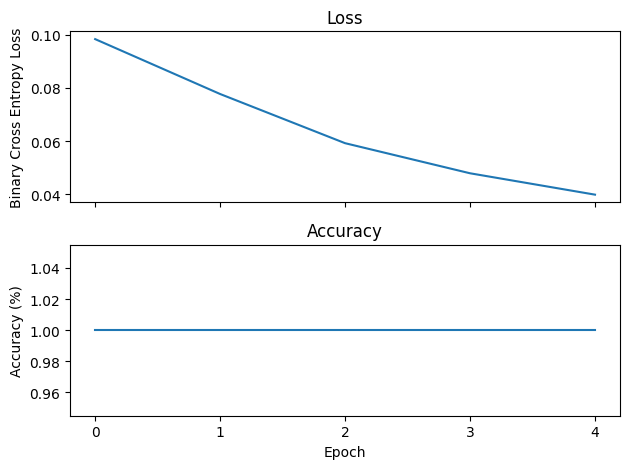

In [7]:
# Plot loss and accuracy over epochs
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(loss_epochs)
ax[0].set_title("Loss")
ax[0].set_ylabel("Binary Cross Entropy Loss")

ax[1].plot(acc_epochs)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")

# Set x ticks to be integers only
for a in ax:
    a.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


fig.tight_layout()

fig.show()

# Batch size manipulation

Batch size 1 correctly causes training to complete within the first epoch with loss being unstable

Batch size == nSamples causes training to be much slower (and not complete within the first 5 epochs)


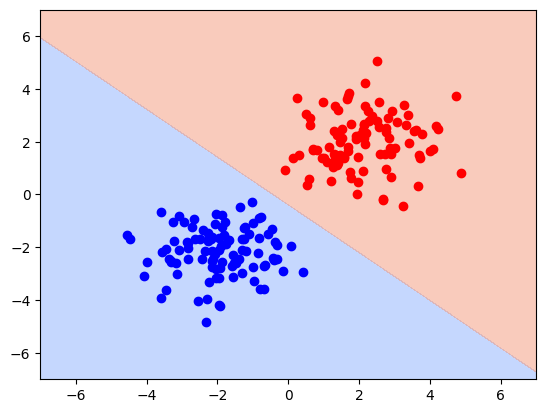

In [8]:
plottest(model, samples)